# Лабораторная работа №3

*Арешин Станислав Олегович М8О-211M-21*

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение, уровень дохода, цель кредита и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

# Предобработка данных

In [2]:
df = pd.read_csv('data.csv')
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


## Train-val-test split

Разбиваем данные сразу на обучение, валидацию и тест в соотношении 70-15-15, так как я планирую построить модель. Далее работаем только с train частью выборки, для преобразований сохраняем парадигму: fit_transform на трейне, на валидации и тесте используем transform.

In [3]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['debt'])

df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42, stratify=df_test['debt'])

print(f'Train shape : {df_train.shape}')
print(f'Val shape : {df_val.shape}')
print(f'Test shape : {df_test.shape}')

Train shape : (15067, 12)
Val shape : (3229, 12)
Test shape : (3229, 12)


## Пропущенные значения

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15067 entries, 7782 to 1816
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          15067 non-null  int64  
 1   days_employed     13547 non-null  float64
 2   dob_years         15067 non-null  int64  
 3   education         15067 non-null  object 
 4   education_id      15067 non-null  int64  
 5   family_status     15067 non-null  object 
 6   family_status_id  15067 non-null  int64  
 7   gender            15067 non-null  object 
 8   income_type       15067 non-null  object 
 9   debt              15067 non-null  int64  
 10  total_income      13547 non-null  float64
 11  purpose           15067 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.5+ MB


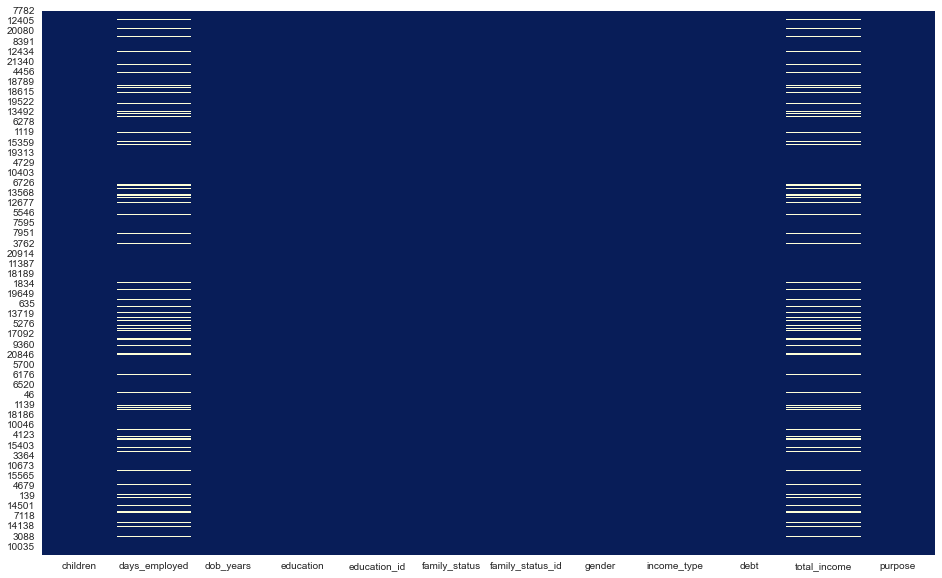

In [5]:
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(df_train.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

Наны в признаках days_employed и total_income, при этом ощущение, что они парные, давайте это проверим

In [6]:
print(f'Length All NaNs: {len(df_train[df_train.isna().any(axis=1)])}')
print(f'Length days_employed NaNs: {len(df_train[df_train.days_employed.isna()])}')
df_train[df_train['days_employed'].isna()][['days_employed', 'total_income', 'income_type']].head()

Length All NaNs: 1520
Length days_employed NaNs: 1520


,days_employed,total_income,income_type
15777,NaN,NaN,сотрудник
8952,NaN,NaN,сотрудник
13906,NaN,NaN,пенсионер
1642,NaN,NaN,сотрудник
15123,NaN,NaN,сотрудник


Так и есть. Скорее всего это связано с тем, что невозможно было получить информацию о стаже и зарплате. Была гипотеза что это только для безработных, но, как видно на выводе, это не так. Это довольно важная информация, поэтому я предлагаю использовать полученный вывод как отдельную бинарную фичу, а сами наны просто закодировать уникальным значением, например -1. В таком случае алгоритм поймет, что -1 это нан по столбцу фич.

In [7]:
from sklearn.impute import SimpleImputer

cols_to_fill = ['days_employed', 'total_income']

imp = SimpleImputer(strategy='constant', fill_value=-1)

to_fill_train = np.array(df_train[cols_to_fill])
fill_result_train = imp.fit_transform(to_fill_train)
df_train[cols_to_fill] = fill_result_train

to_fill_val = np.array(df_val[cols_to_fill])
fill_result_val= imp.transform(to_fill_val)
df_val[cols_to_fill] = fill_result_val

to_fill_test = np.array(df_test[cols_to_fill])
fill_result_test = imp.transform(to_fill_test)
df_test[cols_to_fill] = fill_result_test

In [8]:
df_train['isna_de_ti'] = df_train.apply(lambda row: 1 if row['days_employed'] == -1 else 0, axis=1)
df_val['isna_de_ti'] = df_val.apply(lambda row: 1 if row['days_employed'] == -1 else 0, axis=1)
df_test['isna_de_ti'] = df_test.apply(lambda row: 1 if row['days_employed'] == -1 else 0, axis=1)

## Категориальные признаки

Посмотрим на уникальные значения категорий, может их можно объединить

In [9]:
df_train['education'].unique()

array(['высшее', 'среднее', 'Высшее', 'ВЫСШЕЕ', 'Среднее', 'СРЕДНЕЕ',
       'неоконченное высшее', 'НАЧАЛЬНОЕ', 'Неоконченное высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'начальное', 'Начальное', 'ученая степень',
       'Ученая степень'], dtype=object)

Если образование привести к нижнему регистру, количество категорий сильно уменьшится, давайте это сделаем

In [10]:
df_train['education'] = df_train['education'].str.lower()
df_val['education'] = df_val['education'].str.lower()
df_test['education'] = df_test['education'].str.lower()
df_train['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [11]:
df_train['family_status'].unique()

array(['гражданский брак', 'Не женат / не замужем', 'женат / замужем',
       'в разводе', 'вдовец / вдова'], dtype=object)

In [12]:
df_train['gender'].unique()

array(['F', 'M'], dtype=object)

In [13]:
df_train['income_type'].unique()

array(['компаньон', 'сотрудник', 'пенсионер', 'госслужащий',
       'безработный', 'предприниматель'], dtype=object)

С семейным положением, полом, и типом занятости все окей, оставим так

In [14]:
df_train['purpose'].unique()

array(['на проведение свадьбы', 'недвижимость',
       'сделка с подержанным автомобилем', 'сыграть свадьбу',
       'автомобили', 'покупка жилой недвижимости', 'покупка своего жилья',
       'строительство жилой недвижимости', 'покупка недвижимости',
       'операции с коммерческой недвижимостью', 'высшее образование',
       'получение высшего образования', 'дополнительное образование',
       'жилье', 'операции с жильем', 'приобретение автомобиля',
       'получение дополнительного образования', 'на покупку автомобиля',
       'покупка жилья для семьи', 'свой автомобиль',
       'покупка жилья для сдачи', 'операции со своей недвижимостью',
       'на покупку своего автомобиля', 'операции с недвижимостью',
       'ремонт жилью', 'покупка коммерческой недвижимости',
       'на покупку подержанного автомобиля',
       'строительство собственной недвижимости', 'автомобиль',
       'покупка жилья', 'свадьба', 'профильное образование',
       'сделка с автомобилем', 'образование',
       

Тут тоже можно схлопнуть категории в более общие и уменьшить их количество 

In [15]:
map_dict = {
    'на проведение свадьбы' :  'Свадьба',
    'недвижимость' : 'Недвижимость',
    'сделка с подержанным автомобилем' : 'Авто',
    'сыграть свадьбу' : 'Свадьба',
    'автомобили' : 'Авто',
    'покупка жилой недвижимости' : 'Недвижимость',
    'покупка недвижимости' : 'Недвижимость',
    'операции с коммерческой недвижимостью' : 'Недвижимость',
    'высшее образование' : 'Образование',
    'получение высшего образования' : 'Образование',
    'дополнительное образование' : 'Образование',
    'на покупку автомобиля' : 'Авто',
    'покупка жилья для семьи': 'Недвижимость',
    'свой автомобиль' : 'Авто',
    'покупка жилья для сдачи' : 'Недвижимость',
    'операции со своей недвижимостью' : 'Недвижимость',
    'на покупку своего автомобиля' : 'Авто',
    'операции с недвижимостью' : 'Недвижимость',
    'ремонт жилью' : 'Недвижимость',
    'покупка коммерческой недвижимости' : 'Недвижимость',
    'на покупку подержанного автомобиля' : 'Авто',
    'строительство собственной недвижимости' : 'Недвижимость',
    'автомобиль' : 'Авто',
    'покупка жилья' : 'Недвижимость',
    'свадьба' : 'Свадьба',
    'профильное образование': 'Образование',
    'сделка с автомобилем' : 'Авто', 
    'образование' : 'Образование',
    'заняться высшим образованием' : 'Образование', 
    'строительство недвижимости' : 'Недвижимость',
    'заняться образованием' : 'Образование', 
    'получение образования' : 'Образование',
    'строительство жилой недвижимости' : 'Недвижимость',
    'покупка своего жилья' : 'Недвижимость',
    'жилье' : 'Недвижимость',
    'операции с жильем' : 'Недвижимость',
    'приобретение автомобиля' : 'Авто',
    'получение дополнительного образования' : 'Образование'  
}

Я бы разбил как-то так по смыслу, в идеале отдельно вынести коммерческую недвижимость и тп, но это нюансы, с остальным кажется все окей, применяем

In [16]:
df_train = df_train.replace({'purpose': map_dict})
df_val = df_val.replace({'purpose': map_dict})
df_test = df_test.replace({'purpose': map_dict})

df_train['purpose'].unique()

array(['Свадьба', 'Недвижимость', 'Авто', 'Образование'], dtype=object)

Далее я закодирую все через OneHot Encoder просто потому что так люблю, хотя я планирую использовать бустинг, и в идеале использовать либо label_encoder либо catboost encoder, признаков не так мало и, мне кажется, это упростит задачу для модели и даст небольшой прирост. Это сделаем чуть позже

## Дубли

Посмотрим на полные дубликаты. Если они есть, то просто удалим. Да, я объединял категории, но у нас есть вещественные признаки, совпадение которых будет очень странным, поэтому в данном случае объединение наоборот поможет побороться с некорректными заявками. Например могли быть одинаковые заявки на жилье и покупку жилья или у человека с Высшим образованием и ВЫСШИМ ОБРАЗОВАНИЕМ и тд, я думаю, тут понятно

In [17]:
len(df_train[df_train.duplicated()])

215

In [18]:
df_train.drop_duplicates(keep='first', inplace=True)
df_val.drop_duplicates(keep='first', inplace=True)
df_test.drop_duplicates(keep='first', inplace=True)

print(f'Train shape : {df_train.shape}')
print(f'Val shape : {df_val.shape}')
print(f'Test shape : {df_test.shape}')

Train shape : (14852, 13)
Val shape : (3211, 13)
Test shape : (3218, 13)


## Целочисленные признаки

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [20]:
df_train['children'].unique()

array([ 0,  1,  2,  3, 20, -1,  4,  5], dtype=int64)

Значение -1 - это уже заполненный (не мной) нан, выделим в отдельную фичу также, как делали ранее для стажа и дохода.

Также я бы отдельно добавил признак, что у клиента есть дети

In [21]:
df_train['isna_children'] = df_train.apply(lambda row: 1 if row['children'] == -1 else 0, axis=1)
df_val['isna_children'] = df_val.apply(lambda row: 1 if row['children'] == -1 else 0, axis=1)
df_test['isna_children'] = df_test.apply(lambda row: 1 if row['children'] == -1 else 0, axis=1)

In [22]:
df_train['has_children'] = df_train.apply(lambda row: 1 if row['children'] > 0 else 0, axis=1)
df_val['has_children'] = df_val.apply(lambda row: 1 if row['children'] > 0 else 0, axis=1)
df_test['has_children'] = df_test.apply(lambda row: 1 if row['children'] > 0 else 0, axis=1)

In [23]:
df_train['dob_years'].unique()

array([59, 27, 47, 24, 31, 45, 51, 67, 37, 25, 29, 49, 26, 53, 33, 58, 40,
       55, 57, 52, 48, 44, 41, 64, 42, 35, 39, 23, 68, 50, 30, 60, 46, 61,
       38, 21, 65, 56, 28, 63, 36, 69, 66, 62, 32, 43, 34,  0, 54, 73, 20,
       22, 71, 70, 72, 19, 74], dtype=int64)

In [24]:
print(len(df_train['education_id'].unique()))
print(len(df_train['education'].unique()))

df_train['education_id'].unique()

5
5


array([0, 1, 2, 3, 4], dtype=int64)

Ощущение, что совпадает с типами, давайте посмотрим

In [25]:
pd.Series(df_train['education'].values,index=df_train['education_id']).to_dict()

{0: 'высшее',
 1: 'среднее',
 2: 'неоконченное высшее',
 3: 'начальное',
 4: 'ученая степень'}

Это действительно так, удалим признак с id после стат тестов, так как уже решили делать OneHot

In [26]:
print(len(df_train['family_status_id'].unique()))
print(len(df_train['family_status_id'].unique()))

df_train['family_status_id'].unique()

5
5


array([1, 4, 0, 3, 2], dtype=int64)

Аналогично проверяем

In [27]:
pd.Series(df_train['family_status'].values,index=df_train['family_status_id']).to_dict()

{1: 'гражданский брак',
 4: 'Не женат / не замужем',
 0: 'женат / замужем',
 3: 'в разводе',
 2: 'вдовец / вдова'}

Удаляем после стат тестов

## Вещественные признаки

In [28]:
num_columns = list(df_train.select_dtypes(include=['float64']).columns)
len(num_columns)

2

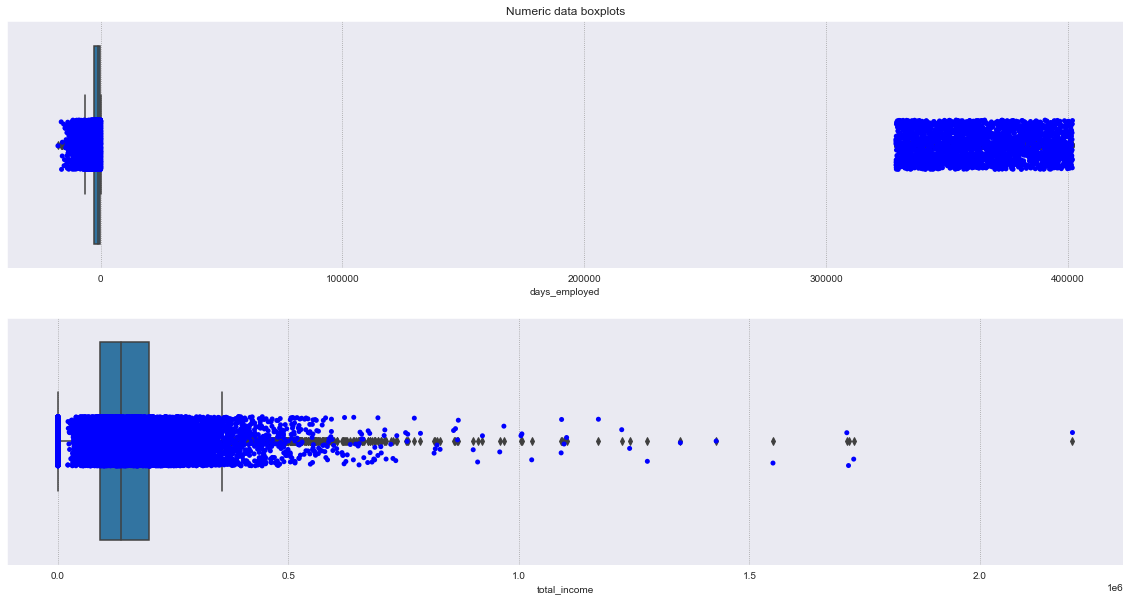

In [29]:
fig = plt.figure(figsize=(20,10))
plt.title('Numeric data boxplots')
plt.axis('off')

for i, column in enumerate(num_columns):
    ax = fig.add_subplot(len(num_columns), 1, i + 1)
    sns.boxplot(x = df_train[column])
    sns.stripplot(x=df_train[column], color='blue')

        
plt.show()

У days_employed много значений < 0, причем по масштабу они очень сильно отличаются от типичных данных. Честно, сложно предположить, с чем это связано и что с этим делать, поэтому я также вынесу это в отдельную фичу, может моделька поймет.

У total_income есть выбросы, но их не супер много, плюс я собираюсь использовать бустинг, а он к ним не очень чувствителен, поэтому оставляем как есть

In [30]:
df_train['days_employed?'] = df_train.apply(lambda row: 1 if row['days_employed'] <= 0 else 0, axis=1)
df_val['days_employed?'] = df_val.apply(lambda row: 1 if row['days_employed'] <= 0 else 0, axis=1)
df_test['days_employed?'] = df_test.apply(lambda row: 1 if row['days_employed'] <= 0 else 0, axis=1)

## Баланс целевой переменной

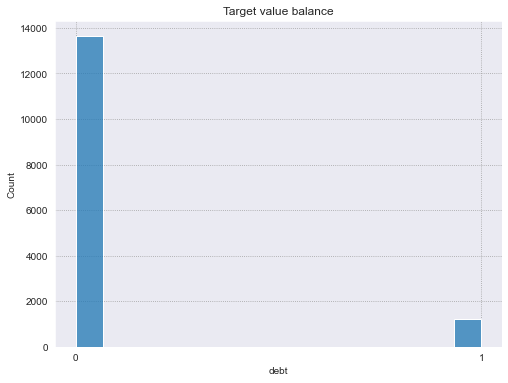

In [31]:
plt.figure(figsize=(8,6))
plt.title('Target value balance')
sns.histplot(data=df_train['debt'])
plt.xticks((0,1))
plt.show()

Ужасный баланс таргета, но это типично для задач кредитного скоринга, так как дефолта обычно довольно мало. Придется с этим работать, благо, обычно в скоринге используют roc_auc и gini, а они устойчивы к разбалансировке выборки.

# Статистические тесты

* Есть ли зависимость между наличием детей и возвратом кредита в срок?
* Есть ли зависимость между семейным положением и возвратом кредита в срок?
* Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
* Как разные цели кредита влияют на его возврат в срок?


Будем использовать критерий Хи-квадрат (зависимость), критерий Спирмана (монотонная зависимость), критерий Пирсона (линейная зависимость). Везде H0 - наблюдения независимы

## Дети и возврат кредита

In [32]:
# зависимость 

from scipy.stats import chi2_contingency

c_tab = pd.crosstab(index=df_train['has_children'], columns=df_train['debt'])

stat, p, dof, expected = chi2_contingency(c_tab)

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.00018528235273868314 ->
Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы


In [33]:
# монотонная зависимость

from scipy.stats import spearmanr

corr, p = spearmanr(df_train['has_children'], df_train['debt'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.00016300161087939857 ->
Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы
Коэффициент корреляции r = 0.03093319961835353


In [34]:
# линейная зависимость

from scipy.stats import pearsonr

corr, p = pearsonr(df_train['has_children'], df_train['debt'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.00016300161087662307 ->
Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы
Коэффициент корреляции r = 0.03093319961835348


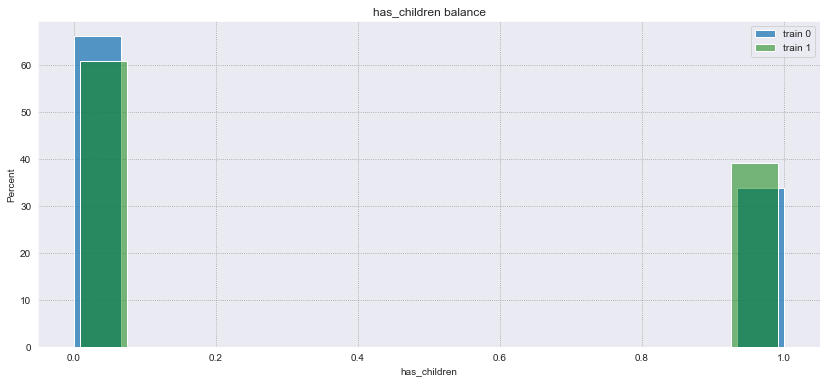

In [35]:
feat = 'has_children'
plt.figure(figsize=(14,6))
plt.title(f'{feat} balance')
sns.histplot(data=df_train[df_train['debt'] == 0], x=feat, label='train 0', stat='percent')
sns.histplot(data=df_train[df_train['debt'] == 1], x=feat, label='train 1',\
                     color='green', stat='percent', shrink=.8, alpha=.5)
plt.xlabel(feat)
plt.legend(['train 0', 'train 1'])
plt.show()

Сработали все 3 критерия. Между наличием детей и возвратом кредита в срок есть монотонная линейная зависимость. Коэф корреляции 0.3. Также визуально на графике видно, что люди с детьми чаще не возвращают кредит в срок, чем люди без детей (график в процентном соотношении)

## Cемейное положение и возврат кредита

In [36]:
# зависимость 

c_tab = pd.crosstab(index=df_train['family_status_id'], columns=df_train['debt'])

stat, p, dof, expected = chi2_contingency(c_tab)

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.0028028232632376026 ->
Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы


In [37]:
# монотонная зависимость

corr, p = spearmanr(df_train['family_status_id'], df_train['debt'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.006854643734811687 ->
Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы
Коэффициент корреляции r = 0.02218549726874408


In [38]:
# линейная зависимость

corr, p = pearsonr(df_train['family_status_id'], df_train['debt'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.023980140789920237 ->
Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы
Коэффициент корреляции r = 0.018523559294806223


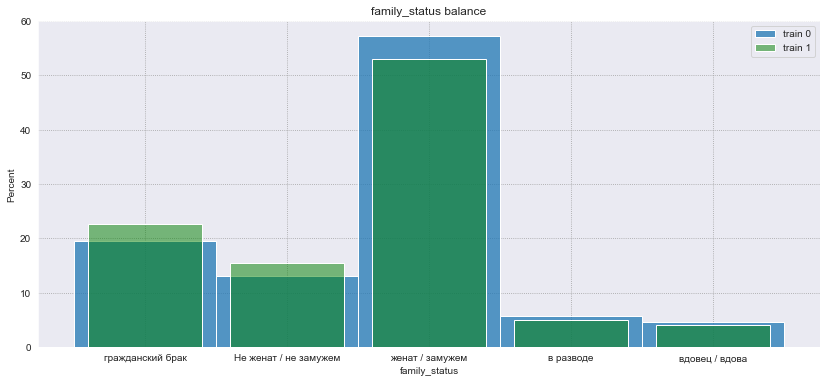

In [39]:
feat = 'family_status'
plt.figure(figsize=(14,6))
plt.title(f'{feat} balance')
sns.histplot(data=df_train[df_train['debt'] == 0], x=feat, label='train 0', stat='percent')
sns.histplot(data=df_train[df_train['debt'] == 1], x=feat, label='train 1',\
                     color='green', stat='percent', shrink=.8, alpha=.5)
plt.xlabel(feat)
plt.legend(['train 0', 'train 1'])
plt.show()

Также сработали все 3 критерия. Между семейным положением и возвратом кредита в срок есть монотонная линейная зависимость. Коэф корреляции 0.18. На графике видно, что люди в гражданском браке и не состоящие в браке чаще не возвращают кредит, это даже в целом логично, так как в браке чаще всего финансы общие и кредиты берутся на общие цели. Для разведенныз и вдовцов/вдов ситуация 50 на 50

## Уровень дохода и возврат кредита

In [40]:
# монотонная зависимость

corr, p = spearmanr(df_train['total_income'], df_train['debt'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.10648011744295818 ->
Не можем отвергнуть H0: нет зависимости между переменными


In [41]:
# монотонная зависимость

corr, p = pearsonr(df_train['total_income'], df_train['debt'])

print(f'p_value = {p} ->')
if p < 0.05:
    print('Отвергаем гипотезу H0: нет зависимости между переменными, переменные зависимы')
    print(f'Коэффициент корреляции r = {corr}')
else:
    print('Не можем отвергнуть H0: нет зависимости между переменными')

p_value = 0.11118261642403654 ->
Не можем отвергнуть H0: нет зависимости между переменными


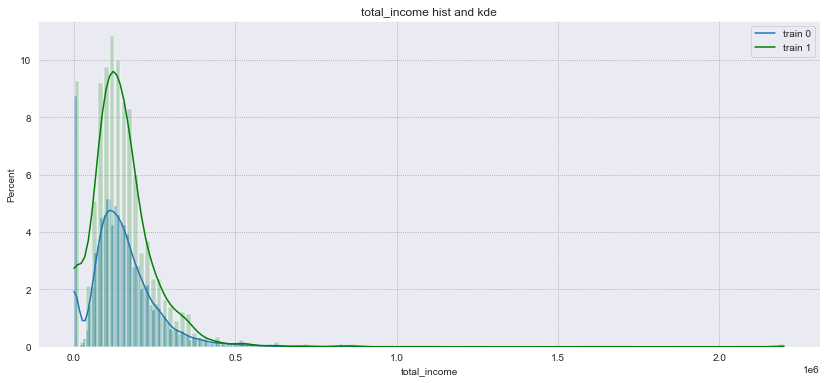

In [42]:
feat = 'total_income'
plt.figure(figsize=(14,6))
plt.title(f'{feat} hist and kde')
sns.histplot(data=df_train[df_train['debt'] == 0], x=feat, label='train 0', kde=True, stat='percent')
sns.histplot(data=df_train[df_train['debt'] == 1], x=feat, label='train 1', kde=True,\
                     color='green', stat='percent', shrink=.8, alpha=.2)
plt.legend(['train 0', 'train 1'])
plt.xlabel(feat)
plt.show()

Нет монотонной зависимости, нет линейной зависимости, хотя визуально кажется, что разделение по плотностям есть. Скорее визуал обманывает из-за разного порядка зарплат, так что можно наверное сказать, что при большой ЗП вероятность возврата больше, чем при маленькой.

## Цели кредита и возврат кредита

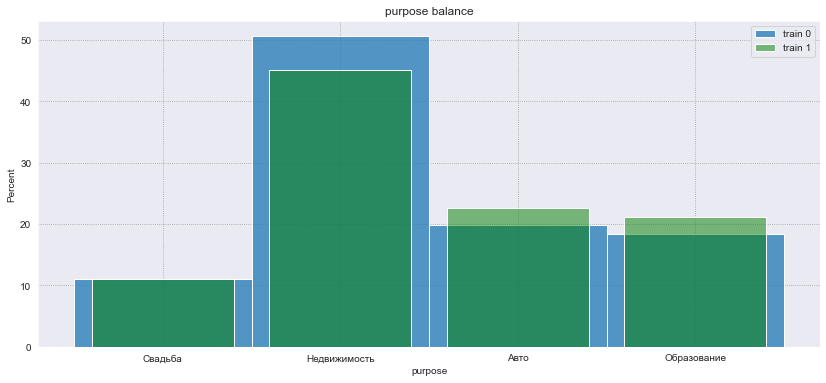

In [43]:
feat = 'purpose'
plt.figure(figsize=(14,6))
plt.title(f'{feat} balance')
sns.histplot(data=df_train[df_train['debt'] == 0], x=feat, label='train 0', stat='percent')
sns.histplot(data=df_train[df_train['debt'] == 1], x=feat, label='train 1',\
                     color='green', stat='percent', shrink=.8, alpha=.5)
plt.xlabel(feat)
plt.legend(['train 0', 'train 1'])
plt.show()

Тут я решил построить только график, видно что для свадьбы ситуация 50 на 50, кредиты на недвижимость чаще возвращаются, чем не возвращаются, а вот у авто и образования наоборот, в процентах больше клиентов, которые не вернули кредит в срок.

# OneHot

Дропаем оставшиеся колонки и делаем OneHot

In [44]:
df_train.drop(['education_id'], axis=1, inplace=True)
df_val.drop(['education_id'], axis=1, inplace=True)
df_test.drop(['education_id'], axis=1, inplace=True)

In [45]:
df_train.drop(['family_status_id'], axis=1, inplace=True)
df_val.drop(['family_status_id'], axis=1, inplace=True)
df_test.drop(['family_status_id'], axis=1, inplace=True)

In [46]:
cat_columns = list(df_train.select_dtypes('object').columns)
cat_columns

['education', 'family_status', 'gender', 'income_type', 'purpose']

In [47]:
from category_encoders.one_hot import OneHotEncoder

encoder = OneHotEncoder(cols = cat_columns, use_cat_names=True)

df_train = encoder.fit_transform(df_train)
df_val = encoder.transform(df_val)
df_test = encoder.transform(df_test)

print(f'Train shape : {df_train.shape}')
print(f'Val shape : {df_val.shape}')
print(f'Test shape : {df_test.shape}')

D:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Train shape : (14852, 31)
Val shape : (3211, 31)
Test shape : (3218, 31)


In [48]:
df_train.head()

,children,days_employed,dob_years,education_высшее,education_среднее,education_неоконченное высшее,education_начальное,education_ученая степень,family_status_гражданский брак,family_status_Не женат / не замужем,...,debt,total_income,purpose_Свадьба,purpose_Недвижимость,purpose_Авто,purpose_Образование,isna_de_ti,isna_children,has_children,days_employed?
7782,0,-2404.645709,59,1,0,0,0,0,1,0,...,0,372580.183620,1,0,0,0,0,0,0,1
10636,0,-949.003202,27,1,0,0,0,0,0,1,...,0,55584.489585,0,1,0,0,0,0,0,1
7295,1,-2551.443820,47,1,0,0,0,0,0,0,...,0,190677.523806,0,0,1,0,0,0,1,1
4027,1,-1320.752994,24,0,1,0,0,0,1,0,...,0,146808.716580,1,0,0,0,0,0,1,1
6441,2,-740.482718,31,0,1,0,0,0,0,0,...,0,72519.077070,0,0,1,0,0,0,1,1


# Модель

Теперь можно сделать бейслайн кредитного скоринга, я буду использовать CatBoost, оценивать по roc_auc и gini, в конце посмотрим на важности.

In [49]:
y_train = np.array(df_train['debt'])
df_train.drop(['debt'], axis=1, inplace=True)
y_val = np.array(df_val['debt'])
df_val.drop(['debt'], axis=1, inplace=True)
y_test = np.array(df_test['debt'])
df_test.drop(['debt'], axis=1, inplace=True)


X_train = np.array(df_train)
X_val = np.array(df_val)
X_test = np.array(df_test)


print(f'Train shape : {X_train.shape}')
print(f'Val shape : {X_val.shape}')
print(f'Test shape : {X_test.shape}')

Train shape : (14852, 30)
Val shape : (3211, 30)
Test shape : (3218, 30)


In [50]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=3000,
                            loss_function = 'Logloss',
                            task_type="CPU",
                            max_depth=7,
                            learning_rate= 0.001,
                            random_state=1
                            )

model.fit(X = X_train,
          y = y_train, 
          eval_set = (X_val, y_val),
          verbose = 250,
          early_stopping_rounds=50)

0:	learn: 0.6920959	test: 0.6921007	best: 0.6921007 (0)	total: 194ms	remaining: 9m 42s
250:	learn: 0.5002734	test: 0.5001447	best: 0.5001447 (250)	total: 5.72s	remaining: 1m 2s
500:	learn: 0.3981884	test: 0.3980358	best: 0.3980358 (500)	total: 10.6s	remaining: 52.7s
750:	learn: 0.3435078	test: 0.3433651	best: 0.3433651 (750)	total: 15.7s	remaining: 47s
1000:	learn: 0.3135157	test: 0.3134741	best: 0.3134741 (1000)	total: 20.5s	remaining: 41s
1250:	learn: 0.2964888	test: 0.2966449	best: 0.2966449 (1250)	total: 25.3s	remaining: 35.4s
1500:	learn: 0.2865034	test: 0.2869645	best: 0.2869645 (1500)	total: 30.1s	remaining: 30.1s
1750:	learn: 0.2803356	test: 0.2812005	best: 0.2812005 (1750)	total: 35s	remaining: 24.9s
2000:	learn: 0.2763729	test: 0.2777124	best: 0.2777124 (2000)	total: 39.9s	remaining: 19.9s
2250:	learn: 0.2735343	test: 0.2754723	best: 0.2754723 (2250)	total: 45s	remaining: 15s
2500:	learn: 0.2714107	test: 0.2740466	best: 0.2740466 (2500)	total: 50.5s	remaining: 10.1s
2750:	lea

In [51]:
from sklearn.metrics import roc_auc_score

val_preds = model.predict_proba(X_val)[:, 1]

print(f'Validation roc_auc score = {roc_auc_score(y_val.reshape(-1), val_preds)}')
print(f'Validation gini score = {2 * roc_auc_score(y_val.reshape(-1), val_preds) - 1}')

test_preds = model.predict_proba(X_test)[:, 1]
print(f'Test roc_auc score = {roc_auc_score(y_test.reshape(-1), test_preds)}')
print(f'Test gini score = {2 * roc_auc_score(y_test.reshape(-1), test_preds) - 1}')

Validation roc_auc score = 0.658347944671732
Validation gini score = 0.31669588934346393
Test roc_auc score = 0.6128927138279582
Test gini score = 0.22578542765591636


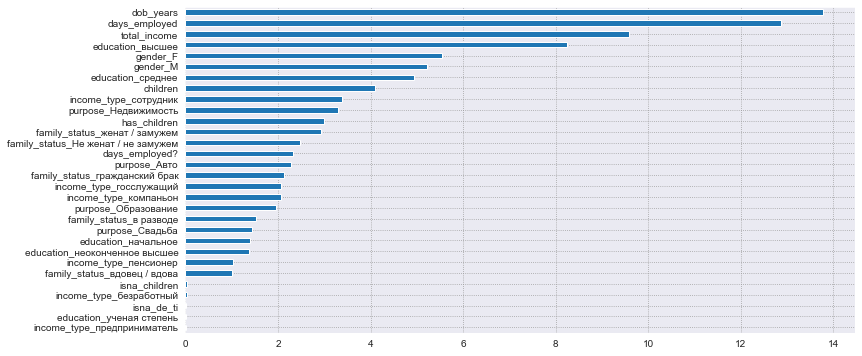

In [52]:
feat_importances = pd.Series(model.feature_importances_, index=df_train.columns).sort_values()
plt.figure(figsize=(12,6))
feat_importances.plot(kind='barh')
plt.show()

Результаты лучше чем 50 на 50, но еще есть куда расти. Модель увидела зависимости между наличием детей и таргетом, мы доказали ее статистически, для гражданского брака, Автокредита, неженатых, и т.д статистические наблюдения также более менее подтверждаются моделью. Наиболее важный признак это возраст, трудовой стаж и доход, также важно чтобы у человека было высшее образование.

В целом видно, что модель находит похожие закономерности, с теми, которые ранее были найдены статистически. Можно провести более подробное исследование, также можно дополнительно поработать с данными, например понять что такое отрицательный стаж, разбить на бины зарплаты и возраст,  нагенерить еще новые признаки, потюнить модель или попробовать другую и тд. Тогда скор точно улучшится, но я пока остановлюсь на этом.